# Machine Learning e Previsão de Entregas

#### **Objetivo:**
Utilizar algoritmos de Machine Learning para prever a variável **`dias_atraso`**.  
Queremos responder: *"Dadas as características do pedido (peso, origem, destino), qual a probabilidade de atrasar?"*

#### **Pipeline de Modelagem:**
1.  **Pré-processamento:** Encoding (transformar texto em números) e Normalização.
2.  **Split:** Divisão entre Treino e Teste.
3.  **Baseline:** Criar um modelo simples (média) para ter uma base de comparação.
4.  **Treinamento:** Rodar algoritmos (Linear Regression, Random Forest, XGBoost).
5.  **Avaliação:** Medir o erro (RMSE/MAE).

## 1. Preparação do ambiente

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.utils import formatar_datetime
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn. pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import os

In [2]:
df_model = pd.read_csv('data/data_model_processed.csv')
df_model = formatar_datetime(df_model)

print('Dataset carregado com sucesso! \n')
display(df_model.info())

Dataset carregado com sucesso! 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110180 entries, 0 to 110179
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   pedido_id               110180 non-null  object        
 1   status_pedido           110180 non-null  object        
 2   data_compra             110180 non-null  datetime64[ns]
 3   data_aprovacao          110180 non-null  datetime64[ns]
 4   data_postagem           110180 non-null  datetime64[ns]
 5   data_entrega            110180 non-null  datetime64[ns]
 6   data_estimada           110180 non-null  datetime64[ns]
 7   preco_produto           110180 non-null  float64       
 8   valor_frete             110180 non-null  float64       
 9   data_limite_postagem    110180 non-null  datetime64[ns]
 10  peso_produto_g          110180 non-null  float64       
 11  comprimento_produto_cm  110180 non-null  float64       
 1

None

## 2. Seleção de features e otimização categórica

Nesta etapa, defini quais variáveis entrarão no modelo e apliquei uma redução de dimensionalidade estratégica.

**Critério de seleção (evitando data leakage):**  
Segui o critério de **causalidade temporal**. Incluí apenas informações conhecidas **no momento da compra** ou postagem (ex: `peso_cubado`, `origem`, `destino`). Excluí propositalmente dados como `data_entrega` ou `tempo_transporte` pois eles contêm a resposta do futuro ("vazamento").

A inclusão da `categoria_produto` foi uma decisão estratégica, pois ela captura nuances logísticas implícitas (como fragilidade e manuseio) que o peso bruto não revela.

**Otimização de dimensionalidade (regra de pareto):**  
Ao analisar a `categoria_produto`, identifiquei 75 valores distintos. Para evitar ruído e alta dimensionalidade, apliquei uma abordagem baseada na **Lei de Pareto (80/20)**:
- **Padronização:** Unifiquei duplicatas (ex: `eletrodomesticos_2` -> `eletrodomesticos`).
- **Corte de representatividade:** Categorias com menos de **500 pedidos** (< 0.5% da base total) foram agrupadas como `'outros'`. Isso reduziu o número de categorias de 75 para **29**, mantendo apenas as que possuem volume estatístico relevante para o aprendizado do modelo.

In [3]:
mapa_correcao = {
    'eletrodomesticos_2': 'eletrodomesticos',
    'casa_conforto_2': 'casa_conforto',
    'pc_gamer': 'pcs',
    'ferramentas_jardim': 'construcao_ferramentas_jardim'
}
df_model['categoria_produto'] = df_model['categoria_produto'].replace(mapa_correcao)

limite_corte = 500
contagem = df_model['categoria_produto'].value_counts()
categorias_irrelevantes = contagem[contagem < limite_corte].index

df_model['categoria_produto'] = df_model['categoria_produto'].apply(
    lambda x: 'outros' if x in categorias_irrelevantes else x
)

print(f"Otimização concluída!")
print(f"Categorias finais mantidas: {df_model['categoria_produto'].nunique()}")

Otimização concluída!
Categorias finais mantidas: 29


In [4]:
feat_num = ['peso_cubado_kg', 'vol_cm3','peso_produto_g', 'tempo_aprovacao', 'prazo_prometido']
feat_cat = ['uf_vendedor', 'uf_cliente', 'flag_pickup', 'categoria_produto']

X = df_model[feat_num + feat_cat]
y = df_model['dias_atraso']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f"\nDivisão concluída!")
print(f"Treino: {X_train.shape[0]} pedidos")
print(f"Teste:  {X_test.shape[0]} pedidos")


Divisão concluída!
Treino: 88144 pedidos
Teste:  22036 pedidos


## 3. Pré-processamento

In [5]:
numb_trnansformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numb_trnansformer, feat_num),
        ('cat', cat_transformer, feat_cat)
    ])

In [6]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Pré-processamento concluído!")
print(f"Quantidade final de colunas (Features): {X_train_processed.shape[1]}")

Pré-processamento concluído!
Quantidade final de colunas (Features): 85


#### 3.1 Análise de balanceamento e estratégia de modelagem

Total de Pedidos: 88144
No Prazo: 82277 (93.34%)
Atrasados: 5867 (6.66%)


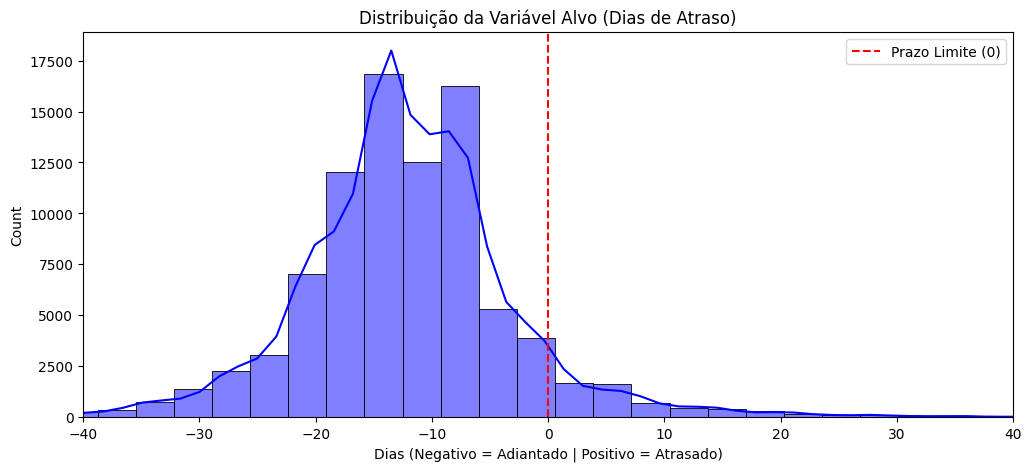

In [ ]:
qtd_atrasados = (y_train > 0).sum()
qtd_no_prazo = (y_train <= 0).sum()
total = len(y_train)

perc_atraso = (qtd_atrasados / total) * 100
perc_no_prazo = (qtd_no_prazo / total) * 100

print(f"Total de Pedidos: {total}")
print(f"No Prazo: {qtd_no_prazo} ({perc_no_prazo:.2f}%)")
print(f"Atrasados: {qtd_atrasados} ({perc_atraso:.2f}%)")

sns.set_style('whitegrid')
%matplotlib inline

plt.figure(figsize=(12, 5))
sns.histplot(y_train, bins=100, kde=True, color='blue')
plt.axvline(0, color='red', linestyle='--', label='Prazo Limite (0)')
plt.title('Distribuição da Variável Alvo (Dias de Atraso)')
plt.xlabel('Dias (Negativo = Adiantado | Positivo = Atrasado)')
plt.xlim(-40, 40)
plt.legend()
plt.show()

Ao analisar o balanceamento do conjunto de treino, identifiquei que a taxa de atrasos é de **6.66%** (5.867 pedidos).

**Insight sobre a Variação (8% -> 6.66%):**
Notei uma leve queda em relação aos ~8% observados na minha Análise Exploratória (EDA) inicial. Isso é um forte indicativo de que **a limpeza de dados foi efetiva**: muitos dos atrasos antigos estavam associados a cadastros inconsistentes (sem vendedor, sem datas válidas) que removi na etapa de saneamento dos dados. O que restou agora é o "atraso operacional puro", mais difícil de prever, mas mais valioso para o negócio.

**Desafio do Desbalanceamento:**
Com 93.3% dos pedidos chegando no prazo, tenho um dataset **altamente desbalanceado**.
* **Risco:** Se o modelo for "preguiçoso" e prever que *nenhum* pedido atrasará, ele terá uma acurácia de 93%, mas será inútil para o negócio (pois falhará em prever o problema).
* **Minha estratégia:** será em não utilizar a **Acurácia** como métrica principal. O sucesso do modelo será medido pelo **Erro Médio (MAE)** e **RMSE**, focando em penalizar erros grandes. O algoritmo *Random Forest* é naturalmente robusto para este cenário, pois a média de múltiplas árvores tende a reduzir o viés da classe majoritária.

## 4. Estratégia de Modelagem e Automação

Para garantir um processo experimental ágil e reprodutível, desenhei uma arquitetura de avaliação baseada em dois pilares:

**1. Automação (pipeline de avaliação):**
Ao invés de repetir código para cada teste, desenvolvi uma função modular (`treinar_e_avaliar`). Isso garante que todos os modelos sejam submetidos rigorosamente aos mesmos dados e avaliados sob as mesmas métricas (**MAE**, **RMSE** e **R²**), permitindo uma comparação justa e direta.

**2. Seleção de algoritmos:**
Minha abordagem consiste em um confronto direto entre três filosofias de modelagem para encontrar o melhor equilíbrio entre performance e complexidade:

- **Regressão Linear:** Escolhi este modelo por sua simplicidade e interpretabilidade. Ele serve como minha "régua de corte". Se modelos mais complexos não superarem significativamente a performance de uma regressão linear simples, não justifica o custo computacional de implementá-los.
- **Random Forest:** Escolhi o *Random Forest* como o primeiro algoritmo avançado por ser um modelo de *Ensemble* (várias árvores de decisão). Ele é ideal para este problema pois lida muito bem com **não-linearidades** e com a alta dimensionalidade gerada pelo *One-Hot Encoding* das categorias e estados, capturando padrões complexos que a reta da regressão linear não consegue enxergar.
- **XGBoost (Gradient Boosting):** Representando o "estado da arte" em dados tabulares. Diferente do Random Forest, ele constrói árvores sequencialmente, onde cada nova árvore tenta corrigir os erros da anterior. Foi incluído para testar se uma abordagem mais agressiva de redução de erro superaria a robustez do Random Forest.

In [8]:
def treinar_e_avaliar(nome_modelo, modelo_instancia, X_tr, y_tr, X_te, y_te):
    """
    Função genérica para treinar e avaliar qualquer modelo.
    Recebe: Nome, Instância do Algoritmo e Dados Brutos.
    Retorna: Dicionário com métricas.
    """
    print(f" Treinando: {nome_modelo}...")
    
    modelo_instancia.fit(X_tr, y_tr)
    
    y_pred = modelo_instancia.predict(X_te)
    
    mae = mean_absolute_error(y_te, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    r2 = r2_score(y_te, y_pred)
    
    print(f'MAE: {mae:.2f} | RMSE: {rmse:.2f} | R2: {r2:.2%}\n')
    
    return {
        'Modelo': nome_modelo,
        'MAE (Erro Médio)': mae,
        'RMSE (Erro Quadrático)': rmse,
        'R²': r2,
        'Modelo_objeto': modelo_instancia
        }

In [ ]:
modelos_para_teste = {
    "Baseline (Regressão Linear)": LinearRegression(),
    
    "Random Forest": RandomForestRegressor(
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1
    ),
    
    "XGBoost": XGBRegressor(
        n_estimators=100, 
        learning_rate=0.1, 
        random_state=42, 
        n_jobs=-1
    )
}

resultados_finais = []

for nome, modelo in modelos_para_teste.items():
    resultado = treinar_e_avaliar(nome, modelo, X_train_processed, y_train, X_test_processed, y_test)
    resultados_finais.append(resultado)
 
df_resultados = pd.DataFrame(resultados_finais).set_index('Modelo')
df_resultados = df_resultados.sort_values(by='MAE (Erro Médio)', ascending=True)

print("COMPARAÇÃO DE PERFORMANCE")
display(df_resultados[['MAE (Erro Médio)', 'RMSE (Erro Quadrático)', 'R²']])

 Treinando: Baseline (Regressão Linear)...
MAE: 5.13 | RMSE: 8.33 | R2: 32.83%

 Treinando: Random Forest...
MAE: 4.73 | RMSE: 8.06 | R2: 37.09%

 Treinando: XGBoost...
MAE: 4.96 | RMSE: 8.07 | R2: 37.01%

COMPARAÇÃO DE PERFORMANCE


,MAE (Erro Médio),RMSE (Erro Quadrático),R²
Modelo,,,
Random Forest,4.731237,8.060347,0.370940
XGBoost,4.957121,8.065877,0.370076
Baseline (Regressão Linear),5.125466,8.329296,0.328260


O *Random Forest* foi quem apresentou o a melhor performace, superou o Baseline, reduzindo o Erro Médio Absoluto (MAE) de **5.13 para 4.73 dias**. Embora o ganho pareça sutil, em escala logística isso representa uma otimização significativa na previsibilidade.  

Embora o XGBoost seja frequentemente superior, o Random Forest demonstrou maior robustez para a complexidade e ruído dos dados logísticos da Olist. O ganho de quase **0.4 dias (aprox. 10 horas)** de precisão média sobre o baseline, multiplicado por milhares de pedidos, representa uma otimização operacional valiosa.

O $R^2$ de **37.09%** indica que conseguimos mapear quase 40% da variância dos atrasos com os dados disponíveis, o que é um resultado robusto considerando a imprevisibilidade de fatores externos (clima, trânsito).

**Feature Importance (O que causa o atraso?):**
Mais importante que a previsão em si é entender os fatores determinantes. Utilizei a propriedade de *Feature Importance* do algoritmo para ranquear quais variáveis mais influenciam o atraso.


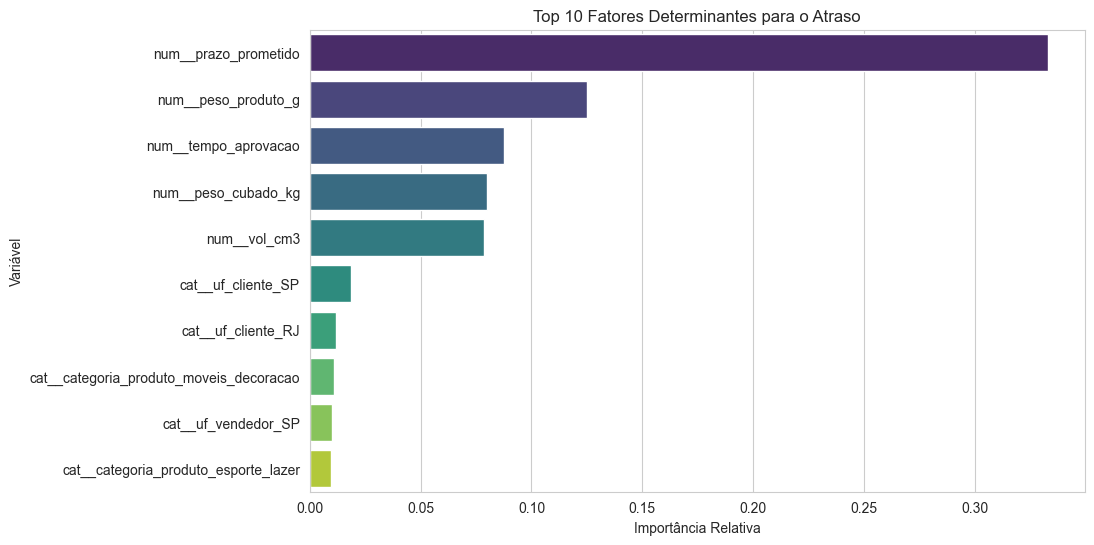

1º Fator mais crítico: num__prazo_prometido
2º Fator mais crítico: num__peso_produto_g
3º Fator mais crítico: num__tempo_aprovacao
4º Fator mais crítico: num__peso_cubado_kg
5º Fator mais crítico: num__vol_cm3
6º Fator mais crítico: cat__uf_cliente_SP
7º Fator mais crítico: cat__uf_cliente_RJ
8º Fator mais crítico: cat__categoria_produto_moveis_decoracao
9º Fator mais crítico: cat__uf_vendedor_SP
10º Fator mais crítico: cat__categoria_produto_esporte_lazer


In [10]:
rf_trained = resultados_finais[1]['Modelo_objeto']
feature_names = preprocessor.get_feature_names_out()

importances = rf_trained.feature_importances_
df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_importance.head(10), x='Importance', y='Feature', hue='Feature', palette='viridis', legend=False)
plt.title('Top 10 Fatores Determinantes para o Atraso')
plt.xlabel('Importância Relativa')
plt.ylabel('Variável')
plt.show()

for i in range(10):
    print(f"{i+1}º Fator mais crítico: {df_importance.iloc[i]['Feature']}")

A análise de **Feature Importance** revelou insights estratégicos valiosos. Os dados mostram que o atraso não é aleatório, mas impulsionado por uma combinação de **gestão de expectativa**, **física** e **processos financeiros**.

**1. A dominância do `prazo_prometido` (fator expectativa):**
* Como esperado, esta variável é a mais determinante. Isso confirma que a definição do SLA (prazo informado ao cliente) é o maior alavancador de atrasos.
* **Insight:** Um prazo mal calculado no checkout gera um atraso estatístico, mesmo que a operação logística seja perfeita.

**2. Peso bruto (`peso_produto_g`) > peso_cubado:**
* Curiosamente, o peso real do produto (2º lugar) impacta mais o atraso do que o volume ou peso cubado (5º e 4º lugares).
* **Insight Logístico:** Isso sugere que a dificuldade operacional está na **carga física**. Itens muito pesados exigem manuseio manual diferenciado, caminhões específicos ou sofrem mais restrições de rotas do que itens apenas "volumosos".

**3. Gargalo invisível: `tempo_aprovacao`:**
* Ocupando o 3º lugar, o tempo que o pagamento leva para ser aprovado é um "assassino silencioso" de prazos.
* **Insight:** O relógio do cliente começa a contar no "clique", mas a logística só começa na "aprovação". Se esse gap for grande, a transportadora tem menos tempo para entregar. O problema aqui é financeiro/sistêmico, não de transporte.

**4. Geografia e categorias críticas:**
* Estados como SP e RJ aparecem no topo, refletindo o alto volume e complexidade de trânsito desses hubs.
* A categoria **móveis e decoração** (8º lugar) valida a tese do peso: móveis costumam ser pesados e de difícil manuseio, aumentando o risco de atraso.

**Conclusão Estratégica:**
Para reduzir os atrasos, a Olist não precisa apenas de caminhões mais rápidos. As ações de maior impacto seriam:
1.  Recalibrar o algoritmo de **prazo prometido**, principalmente para itens pesados.
2.  Agilizar o gateway de pagamento para reduzir o **tempo de aprovação**.

### 4.1 TUNING COMPARATIVO

Vamos tunar os dois melhores modelos 

In [11]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2], 
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 1.0]
}

modelos_para_tuning = [
    ('Random Forest', RandomForestRegressor(random_state=42, n_jobs=-1), param_grid_rf),
    ('XGBoost', XGBRegressor(random_state=42, n_jobs=-1), param_grid_xgb)
]

resultados_tuning = []

for nome, modelo, grid in modelos_para_tuning:
    print(f"\n--- Otimizando {nome}... ---")
    
    random_search = RandomizedSearchCV(
        estimator=modelo,
        param_distributions=grid,
        n_iter=10,
        cv=3,  
        scoring='neg_mean_absolute_error',
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    random_search.fit(X_train_processed, y_train)
    
    best_model = random_search.best_estimator_
    y_pred_tuned = best_model.predict(X_test_processed)
    
    mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
    rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
    
    print(f' Melhor {nome}: MAE {mae_tuned:.4f} | Params: {random_search.best_params_}')
    
    resultados_tuning.append({
        'Modelo': f'{nome} (Tuned)',
        'MAE (Erro Médio)': mae_tuned,
        'RMSE (Erro Quadrático)': rmse_tuned,
        'Modelo_objeto': best_model
    })

df_tuning = pd.DataFrame(resultados_tuning).set_index('Modelo')
df_tuning = df_tuning.sort_values(by='MAE (Erro Médio)', ascending=True)

print('\n Resultado final pós-tuning:')
display(df_tuning)

melhor_modelo_final = resultados_tuning[0]['Modelo_objeto']


--- Otimizando Random Forest... ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
 Melhor Random Forest: MAE 4.7664 | Params: {'n_estimators': 200, 'min_samples_leaf': 2, 'max_depth': 30}

--- Otimizando XGBoost... ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
 Melhor XGBoost: MAE 4.8508 | Params: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05}

 Resultado final pós-tuning:


,MAE (Erro Médio),RMSE (Erro Quadrático),Modelo_objeto
Modelo,,,
Random Forest (Tuned),4.766407,7.978510,"(DecisionTreeRegressor(max_depth=30, max_featu..."
XGBoost (Tuned),4.850763,7.935839,"XGBRegressor(base_score=None, booster=None, ca..."


## 5. Conclusão e Decisão Final

**Resultado Final:**
O modelo campeão foi o **Random Forest (Parâmetros Padrão)**, atingindo o menor erro entre todos os testes: **MAE de 4.73 dias**.

**Análise dos Experimentos:**
1.  **Baseline vs. Machine Learning:** O uso de IA reduziu o erro em cerca de **10 horas médias por pedido** em comparação à Regressão Linear.
2.  **Complexidade Desnecessária:** Testes com algoritmos de *Gradient Boosting* (XGBoost) e processos de *Hyperparameter Tuning* (ajuste fino) não superaram o desempenho do Random Forest padrão. Isso indica que a configuração original do algoritmo já foi suficiente para capturar o padrão máximo dos dados ("teto de performance"), tornando desnecessário o custo computacional extra de modelos mais complexos.

**Entrega:**
O modelo final foi encapsulado em um *Pipeline* (incluindo todo o pré-processamento necessário) e exportado para o arquivo `modelo_previsao_atraso_olist.pkl`. Ele está pronto para ser integrado em sistemas de produção, capaz de receber dados brutos de um novo pedido e devolver a previsão de atraso instantaneamente.

In [12]:
final_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

pipeline_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', final_model)
])

X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

pipeline_final.fit(X_full, y_full)
print("Pipeline Final treinado com 100% dos dados!")

destino = 'models'
if not os.path.exists(destino):
    os.makedirs(destino)
    
nome_arquivo = 'modelo_previsao_atraso_olist.pkl'
caminho_completo = os.path.join(destino, nome_arquivo)
joblib.dump(pipeline_final, caminho_completo)

print(f"\n Sucesso! Modelo salvo em: {nome_arquivo}")
print("Para usar depois, basta rodar: modelo = joblib.load('modelo_previsao_atraso_olist.pkl')")

Pipeline Final treinado com 100% dos dados!

 Sucesso! Modelo salvo em: modelo_previsao_atraso_olist.pkl
Para usar depois, basta rodar: modelo = joblib.load('modelo_previsao_atraso_olist.pkl')
